# Tutoriel sur les réseaux neuronaux récurrents

Commençons par le commencement : installer pytorch et certains modules nécessaires pour compléter ce tutoriel. 

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
from random import randint
import numpy as np
import time

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch import optim
torch.backends.cudnn.version()

import matplotlib
import matplotlib.pyplot as plt

cuda = True

## Module utilitaire



In [0]:
def data_set(N, T, interval):
    ''' 
    inputs : 
    N : nombre de données 
    T : longueur de la séquence
    interval : l'intervalle dans lequel les nombres seront tirés pour générer les séquences. 
    
    outputs: retourne les séquences (xx) et les cibles (yy), en format torch.tensor
        
    '''
    N = int(N)
    
    x = torch.Tensor(N, T)
    y = torch.Tensor(N)
    
    for i in range(N):
        x[i] = (torch.Tensor(T).random_(0,2*interval[1]) + interval[0]) #/ interval[1]
        y[i] = torch.sum(x[i])
    return x, y
  

def print_sequence(x, y):
    '''
    x : Une séquence particulière, i.e dim(x) = 1 x T
    y : Cible liée à cette même séquence, i.e. dim(y) = 1
    retourne une série de caractères illustrant la séquence 
    dans un format convivial. 
    '''
    n = x.shape[0]
    for i, x_ in enumerate(x):
        if i == 0 : 
            string=' '+str(x_)
        else: 
            string=string+' + '+str(x_)

    return string+' = '+str(y)
  
def adjust_lr(optimizer, lr0, epoch, total_epochs):
    '''
    Cette fonction diminue le taux d'apprentissage suivant une fonction 
    exponentielle avec le nombre d'époque. 
    
    optimizer: e.g. optim.SGD(... )
    lr0 : taux d'apprentissage initial
    epoch : époque à laquelle la mise à jour est effectuée. 
    total epochs: nombre d'époque totale
    
    exemple : 
    
    new_learning_rate = adjust_lr(optimizer, 0.01, e_, 100)
    
    '''
    
    lr = lr0 * (0.36 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def batch_loss(data_batch,model): 
    '''
    Cette fonction calcule le loss d'un jeu de donnée divisé en plusieurs   
    batchs. C'est nécessaire pour traiter de grandes quantités de données.     
    '''
    loss = 0
    total = 0
    for batch_idx, (x, y) in enumerate(data_batch):
        x, y = model.input_format(x, y)
        out = model(x)
        loss += model.criterion(out, y)
        
    return loss.data[0]
  
  
def adjust_fontsize(ax):
  '''
  Par déformation professionnelle, j'ai le souci de préparer de belles figures. 
  Cette fonction est un clin d'oeil pour mon ancien superviseur de thèse.
  '''
  for ax in ax:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(14)  
  

## Objectif

L'objectif de ce tutoriel est de construire un modèle capable d'additionner ou soustraire une série de nombres. Ce jeu de données est facile à générer et nous permet de tester la capacité de plusieurs algorithmes tels que,

* LSTM 
* RNN vs. LSTM (dropout)
* MLP

Le jeu de données est constitué d'une séquence de nombre de longueurs *seq_len* , à laquelle une cible est associée. Dans l'exemple ci-dessous, la i$^{eme}$ composante des données est explicitement détaillée (voir la Fig. 1). 

\begin{align}  
\mathrm x^{(i)} &= \left[ 4,-1,15,24\right], \mathrm x^{(i)} \in \mathbb R^{d_0} \\ 
\mathrm y^{(i)} &= 42, \mathrm y^{(i)} \in \mathbb R 
\end{align}

Il est important de noter que chaque composante du vecteur $\mathrm x^{(i)}$, peut être de plusieurs dimensions, c'est-à-dire $x^{(i)}_j \in \mathbb R^{d_1}$ où $d_1 > 1$. 


![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.003.jpeg)

Fig.1 : Jeu de données considéré. 

Ce jeu de donné peut ainsi servir à entrainer un modèle de réseau de neurones récurrents (RNN), tel que le _long short term memory_(LSTM). Dans ce cas, chaque nombre sera l'entrée d'une couche cachée (_hidden layer_) de dimension $h_d$. 

Comme la cible est un nombre réel, il est nécessaire de rajouter une couche linéaire au modèle pour "ajuster" les dimensions (voir la Fig.2). Cette notion sera expliquée à l'aide d'un exemple détaillé ci-bas. 

![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.004.jpeg)


Fig.2 : Shéma d'un réseau récurrent. 

## Réseau de neuronnes récurrents (LSTM)

### Générer une couche LSTM
###  __ = nn.LSTM(input_size, hidden_size, num_layers)

Une couche LSTM peut incorporer plusieurs paramètres régis par le jeu de données (*input_size*), mais aussi d'autres paramètres essentiels pour optimiser la capacité du modèle, tels que *hidden_size*, *num_layers*, etc.

![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.001.jpeg)

Fig. 3: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

### Entrés d'une couche LSTM (*inputs*)
### __ = LSTM(*input*, (h0,c0))

En plus des données (_input_), il est aussi possible d'initialiser les tenseurs h_0, c_0 qui définissent les LSTMs. 

__Dans le cas où $h_0$ et $c_0$ ne sont pas définis, le module LSTM utilisera les valeurs par défaut, i.e. 0.__

![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.002.jpeg)

Fig. 4: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

### Donnée d'entrée (*input*)
__<font color='red'>input</font> =  torch.Tensor(seq_len, batch_size, input_size) __

Il est nécessaire de réorganiser les données d'entrées (input) selon trois paramètres : 

* la longueur de la séquence (seq_len)
* la grandeur du lot (batch, i.e. batch_size)
* les dimensions des entrées (input_size)

Créons un jeu de données $\bf x$ composés de 100 séquences de 4 nombres entre 0 et 100. Les cibles $\bf y$ correspondent à la somme de chacune de ces séquences. La fonction *data_set* située dans la section *Module utilitaire* s'occupe de cette tâche fastidieuse. 
 


In [53]:
x,y = data_set(100, 4, [-100, 100])

print(x.shape)
print(y.shape)

torch.Size([100, 4])
torch.Size([100])


In [54]:
sequence = print_sequence(x[1,:] ,y[1])

print(sequence)
print('Dimensions des entrées : '+str(x.shape[0])+' x '+str(x.shape[1]))

 95.0 + 24.0 + -47.0 + 45.0 = 117.0
Dimensions des entrées : 100 x 4


__Q1__ : Selon l'exemple ci-haut, quels sont les paramètres d'entrées? On considéra ici qu'un seul lot (*batch*). 

* seq_len = 
* batch_size = 
* input = 

Réponse : 4, 100, 1

In [55]:
# RÉPONSE: 
x_ = x.transpose(1,0)[:,:,np.newaxis]
y_ = y[:,np.newaxis].type(torch.FloatTensor)

# ...

print('Dimensions du tenseur x = '+str(x_.shape))
print('-------------------------------------------------')
print('    ')

print('Plus en détails: ')
print('-----------------')
print('    ')

dimensions = x_.shape
print('seq_len = %.f   batch_size = %.f     input_size = %.f'%(dimensions))

Dimensions du tenseur x = torch.Size([4, 100, 1])
-------------------------------------------------
    
Plus en détails: 
-----------------
    
seq_len = 4   batch_size = 100     input_size = 1


__Q2__  : Donnez un exemple où les dimensions d'entrées seraient supérieures à un, c.-à-d. *input* $> 1$.

Réponses : 
* chaque mot d'une phrase est représenté par un vecteur de dimension égale à la grandeur du vocabulaire. 
* température réelle, vent, température ressentie vs. t
* variation boursière 

![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.006.jpeg)


Fig.5 : Shéma d'un réseau récurrent. 

### Donnée de sortie (*output*)
### output = LSTM(*input*, (h0,c0))
__<font color='red'>output</font> = torch.tensor(seq_len,batch_size, hidden_size x num_directions) __


Les dimensions du tenseur "output_0" sont déterminées par: (*seq_len*, *batch*, *hidden_size* $\times$ *num_directions*). 

Dans le cas qui nous intéresse, num_directions $ = 1$. 

![Texte alternatif…](https://raw.githubusercontent.com/jphreid/rnn_tutorial/master/lstm-figures.005.jpeg)

Fig.6 : http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

__Q3__  : Construisez votre première couche LSTM. Nous vous référons au lien dessous la Fig. 3 pour plus de détails et exemples. 

In [56]:
# do it! 

# réponse : 

# les paramètres
input_size = 1
hidden_size = 6
num_layers = 1

# lstm  
lstm = nn.LSTM(input_size, hidden_size, num_layers)

# forward 
output_0, (hn, cn) = lstm(Variable(x_))

print(output_0.shape)


torch.Size([4, 100, 6])


### Réorganiser les dimensions de la sortie ("<font color='red'>output_0</font>") 

Tel que mentionné ci-haut, seule la dernière composante du tenseur "output_0" sera considérée pour prédire la cible associée à une séquence (voir Fig.2). 

Exemple: considérons la $41^e$ séquence ainsi que la couche associée. 

In [57]:
print(x_[:,41,:])
print(y_[41])

sequence = print_sequence(x[41,:],y[41])
print(sequence)


 20
-27
 78
-38
[torch.FloatTensor of size 4x1]


 33
[torch.FloatTensor of size 1]

 20.0 + -27.0 + 78.0 + -38.0 = 33.0


In [58]:
output_0[:,41,:]

Variable containing:
-1.0519e-02  4.4317e-03  7.0183e-06 -1.0821e-01 -8.9133e-03 -1.7061e-05
-7.5965e-01  6.8485e-01 -7.6094e-01  1.5785e-01  1.3620e-03  7.6039e-01
-2.0192e-08  1.3835e-09 -5.2700e-12 -1.3382e-02  7.6138e-01  3.0699e-11
-7.6148e-01  7.5061e-01 -7.6157e-01  2.2857e-01  1.1303e-04  7.6211e-01
[torch.FloatTensor of size 4x6]

Tel que mentionné ci-haut, seule la quatrième (dernière) composante du tenseur output_0 qui doit être considéré (voir Fig. 2).

In [59]:
output_0[-1,41,:]

Variable containing:
-0.7615
 0.7506
-0.7616
 0.2286
 0.0001
 0.7621
[torch.FloatTensor of size 6]

__Q4__  : Proposez une stratégie pour transformer le tenseur "output_0" de dimensions [4,100,10] à un tenseur de dimensions voulues, c.-à-d. [100,1]. Spécifiquement, quelle opération mathématique permettra d'obtenir les dimensions voulues? 
    * Réponse : Effectuer un produit tensoriel entre output_0 et une matrice "M" dont le résultat est de dimensions voulues, c.-à-d. 100 x 1

\begin{align}
\text{output} =  \text{output_0}\;  M 
\end{align}
Dans le cas qui nous intéresse, les dimensions du tenseur "M" sont de *hidden_size* $\times 1$


In [60]:
## Question

# 1e partie: générez un tenseur M de dimensions voulues et utilisez la fonction 'torch.matmul' pour  multiplier M et output_0. 
M = Variable(torch.Tensor(hidden_size, 1))
output = torch.matmul(output_0[-1], M)

# 2e partie: gérérez une couche linéaire de dimensions voulues avec la fonction 'LL = nn.Linear(...)'. L'entrée de LL sera output_0. 

LL = nn.Linear(hidden_size, input_size,bias=True)
output = LL(output_0[-1])
print(output.shape)

torch.Size([100, 1])


# Construction du modèle

Il est fortement suggéré d'utiliser des classes pour définir les modèles dans l'environnement Pytorch, et ce peu importe son architecture. 


__Q5__  : Écrivez la fonction RnnLinear.forward(). Cette fonction aura comme entrée *self* et le tenseur $\bf x$ de dimension T x N x 1. 

Indice : le output_0 de la couche LSTM ou RNN sera l'entrée de la couche lineaire. 



In [0]:
class RnnLinear(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, lstm_or_rnn,cuda):
        ''' More details here ...  '''
        num_directions = 1
        super(RnnLinear, self).__init__()
        
        # parametres importants 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_or_rnn = lstm_or_rnn      
        
        # couches de notre réseau 
        if lstm_or_rnn == 'lstm':
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout = 0.3)
            if cuda : self.lstm.cuda() 
              
        elif lstm_or_rnn == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers,dropout = 0.3)
            if cuda: self.rnn.cuda()
              
        else: print('You made a mistake, pal!')
        
        self.linear = nn.Linear(hidden_size, input_size,bias=True)
        if cuda: self.linear.cuda()
              
        # criteria for SGD
        self.criterion = nn.MSELoss()
        
    def input_format(self,x,y):
        '''
        Cette fonction permet de préparer les dimensions des données d'entrées. 
        '''

        # Transpose est nécessaire pour inverser batch_size et seqlen.  
        x = x.transpose(1,0)[:,:,np.newaxis]
        y = y[:,np.newaxis].type(torch.FloatTensor)
        if cuda : 
            x = Variable(x.cuda())
            y = Variable(y.cuda())
        else: 
            x = Variable(x)
            y = Variable(y)
        return x,y

    def grad_norm(self):
        total_norm=0
        for p in list(self.parameters()):
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm ** 2

        return total_norm
  
    def forward(self,x):
        '''
        Cette fonction devrait inclure des conditions if/elif sur la variable 
        self.lstm_or_rnn. La sortie des couches LSTM et RNN seront les entrées 
        de la couche linéaire. 
        '''
        
        # cas où self.lstm_or_rnn = 'rnn'
        if self.lstm_or_rnn == 'rnn':
            out1,(__) = self.rnn(x)

        # cas où self.lstm_or_rnn = 'lstm'      
        if self.lstm_or_rnn == 'lstm':
            out1,(__) = self.lstm(x)

        # votre couche linéraire             
        out2 = self.linear(out1[-1])

        return out2

Construisons le jeu de données d'entrainement, de validation et de test. 

In [0]:
'''
Train : N = 10000, T = 5, Les nombres de chaque séquence sont tirées entre 0 et 100. 
Valid : N = 1000
Talid : N = 1000
'''
xtrain,ytrain = data_set(20000, 5, [0,100])
xvalid,yvalid = data_set(1000, 5, [0,100])
xtest,ytest = data_set(1000, 5, [0,100])

batch_size = 80

'''
Il est possible de générer un objet 'data_utils.TensorDataset(x,y)' qui rassemble toutes les données. 
Cet objet peut être utilisé pour segmenter les données en batch 'data_utils.DataLoader.
'''

# data_utils.TensorDataset(x,y) : http://pytorch.org/docs/master/data.html?highlight=tensordataset#torch.utils.data.TensorDataset
# data_utils.DataLoader(dataset, bactch, argms): http://pytorch.org/docs/master/data.html?highlight=tensordataset#torch.utils.data.DataLoader

all_data_train = data_utils.DataLoader(data_utils.TensorDataset(xtrain, ytrain), batch_size, shuffle=True)
all_data_valid = data_utils.DataLoader(data_utils.TensorDataset(xvalid, yvalid), batch_size, shuffle=True)
all_data_test = data_utils.DataLoader(data_utils.TensorDataset(xtest, ytest), batch_size, shuffle=True)


In [68]:
sequence = print_sequence(xtrain[0,:], ytrain[0])
print(sequence)

 61.0 + 3.0 + 146.0 + 126.0 + 111.0 = 447.0


In [69]:
print('Nombre de lots "batch":')
print(len(list(all_data_train)))

Nombre de lots "batch":
250


Testons notre modèle ... 

In [73]:
input_size = 1
num_layers = 2
hidden_size = 20

model = RnnLinear(input_size, hidden_size, num_layers, 'lstm', cuda)

xx,yy = model.input_format(xtrain, ytrain)
print('Dimensions initiales des données : '+str(xtrain.shape))
print('Dimensions initiales des données : '+ str(xx.shape))

pred = model(xx)
print('Dimensions des prédictions : '+str(pred.shape))

print('Success!')

Dimensions initiales des données : torch.Size([20000, 5])
Dimensions initiales des données : torch.Size([5, 20000, 1])
Dimensions des prédictions : torch.Size([20000, 1])
Success!


### Entraînement du modèle

#### Questions 
__Q6__

Construisez la boucle d'entrainement ci-bas. 

__Q7__

Entrainez le modèle sur 100 époques avec ces différents paramètres et hyperparamètres, c.-à-dire N = 10000, T = 5, intervalle = [0,100], $h_d$ = 20, num_layers = 2, lr0 = 0.05. 

Comparez les prédictions obtenues par le modèle aux cibles. Chaque cible devrait être toutes semblables. À quoi correspond cette valeur? 

__Q8__

Pour remédier à ce problème, nous vous suggérons d'augmenter le nombre de données à 20000, c.-à-d. N = 20000. Comparez les résultats à ceux précédents. 

__Q9__ 

Augmentez la capacité du modèle, en fixant $h_d$ = 100. Comparez les résultats à ceux précédents.

__Q10__ 

Finalement, normaliser les données de chaque séquence par son maximum, c.-à-d. 100. Vous devrez modifier la fonction *data_set* définie dans la section *Module utilitaire*. Élargissez aussi l'intervalle de tirage de -100 à 100. 

__Q11__ 

Explorez différents valeurs d'hyperparamètres. 

* lr = 0.1, 1, 0.00001

* hidden_size = 400, 20

* dropout = 0.5, 1

Enjoy! 


In [74]:
input_size = 1
num_layers = 2
hidden_size = 20
number_epoch = 20
lr0 = 0.05

model = RnnLinear(input_size, hidden_size, num_layers,'lstm',cuda)
optimizer = optim.SGD(model.parameters(),lr=lr0)


t0 = time.clock()

# tableau à remplir lors de la phase d'entrainement 
loss_train_data = np.array([]) 
loss_valid_data = np.array([]) 

total_norm = np.array([])

t0 = time.clock()  

# Prêt pour entrainer
model.train()
for e_ in range(number_epoch):
  
  # model.train(), poruquoi? Indice : dropout   
  model.train()
  for batch_idx, (xx, yy) in enumerate(all_data_train):                
    # Formatez les données
    xx,yy = model.input_format(xx,yy)
    
    # Évaluez le modèle 
    pred_batch = model(xx)
    
    # Initialisez les gradients
    optimizer.zero_grad()
    
    # Calculez la loss  
    loss_batch = model.criterion(pred_batch,yy)
    
    # SGD backward 
    loss_batch.backward()
    
    # SGD optimized
    optimizer.step()
    
    # stop. 
  
  # Calculez la norm de tous les gradients 
  total_norm = np.append(total_norm,model.grad_norm())

  # model.eval(), poruquoi? Indice : dropout 
  model.eval()  

  loss_train_data = np.append(loss_train_data, batch_loss(all_data_train,model)) 
  loss_valid_data = np.append(loss_valid_data, batch_loss(all_data_valid,model))

  if e_%20 == 0: 
    print('N. of Epochs = %.f, Train Loss = %.4f, Valid Loss = %.4f'
          %(e_, loss_train_data[e_], loss_valid_data[e_]))

  lr_ = adjust_lr(optimizer, lr0, e_, number_epoch)

tf = time.clock()
print('Terminé, %.1f sec'%(tf-t0))

N. of Epochs = 0, Train Loss = 4391095.0000, Valid Loss = 215692.4375
Terminé, 29.1 sec


### Prédiction du modèle

#### Question

Il est possible d'activer ou d'ésactivé l'option dropout de notre modèle en appelant 'model.eval()' et 'model.train()'.

__Q12__ : Pourquoi est-il nécessaire de désactivé l'option 'dropout' lors des phases test et validation? 

In [0]:
# prêt pour évaluer
model.eval()

# prêt pour entraîner
# model.train()

xtest_,ytest_ = model.input_format(xtest, ytest)
pred_test_all = model(xtest_)
L1_loss = torch.sum(torch.abs(pred_test_all - ytest_)).data[0]



In [76]:
print('LSTM L1 loss = '+str(L1_loss))
print('      ')
print('Prediction')
print('___________________')
print(pred_test_all[0:10])
print('      ')
print('Target')
print('___________________')
print(ytest_[:10])

LSTM L1 loss = 103689.734375
      
Prediction
___________________
Variable containing:
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
 504.4336
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

      
Target
___________________
Variable containing:
  198
  410
  540
  755
  601
  372
  597
  482
  591
  586
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



### Prédiction sur des séquences de longueurs différentes

#### Question

__Q13__ : Prouvez qu'il est aussi possible d'utiliser ce modèle pour prédire des séquence d'une longueur différente.

In [30]:
T_= 10

xx,yy = data_set(1,T_,[-100,100])
xx,yy = model.input_format(xx,yy)

print('Séquence de longueur %.f'%T_)
print('--------------------------')
print('Prédiction: %.4f'%model(xx).data[0])

print('Cible: %.4f'%yy.data[0])
print('LSTM L1 loss: %.4f'%(torch.abs(model(xx).data[0]-yy.data[0])))



Séquence de longueur 10
--------------------------
Prédiction: -0.7839
Cible: -0.7100
LSTM L1 loss: 0.0739


### Courbes d'apprentissage

Nous traçons plus bas deux graphiques d'importance capitale : 

* Courbes d'apprentissage, i.e. loss vs. époque pour l'ensemble de validation et d'entrainement. 
* La norme de tous les gradients évaluée à chaque époque. 


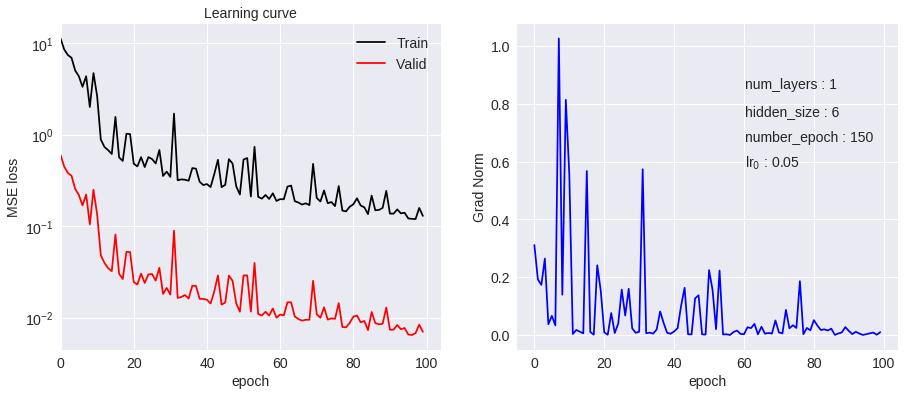

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.semilogy(loss_train_data,'-k',label='Train')
ax1.plot(loss_valid_data,'-r',label='Valid')

ax2.plot(total_norm,'-b',label='Grad')


ax1.set_xlabel('epoch',fontsize=14)
ax2.set_xlabel('epoch',fontsize=14)
ax1.set_ylabel('MSE loss',fontsize=14)	
ax2.set_ylabel('Grad Norm',fontsize=14)	
legend = ax1.legend(loc='upper right',fontsize=14)

ax1.set_xlim((0))

ax1.set_title('Learning curve', fontsize = 14)
ax1.set_title('Learning curve', fontsize = 14)

xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()

ax2.text(0.6*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,
         'num_layers : '+str(num_layers), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.72*(ymax-ymin) + ymin,
         'hidden_size : '+str(hidden_size), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.64*(ymax-ymin) + ymin,
         'number_epoch : '+str(number_epoch), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.56*(ymax-ymin) + ymin,
         'lr$_0$ : '+str(lr0), fontsize=14)


adjust_fontsize([ax1,ax2])
plt.show()          




#### Question

__Q14__ : Dans le graphique ci-haut, comment expliquez-vous que la norme diminue et converge vers zéro avec le nombre d'époques? 

...

# Comparaison entre RNN et LSTM

__Q15__ :  Entrainez le modèle ci-bas pour les hyperparamètres suivants:

* N = 20000
* $h_d$ = 20, 50, 100
* number_epoch = 1
* batch_size = 100
* lr0 = 0.005
* T = 50

Vous devriez rencontrer un problème. Comment proposez-vous de le résoudre? 



__Q16__ : Entrainez le modèle ci-bas pour ces séries d'hyperparamètres et comparez les performances des modèles RNN et LSTM. 

Nous vous suggérons de remplacer 'if epoch%1 == 0: ' par 'if epoch%10 == 0: '

* N = 20000
* $h_d$ = 20
* number_epoch = 100
* batch_size = 100
* lr0 = 0.005

  * T = 3, 5, 10, 15, 20, 30, 100
  





In [32]:
cuda = True 

input_size = 1
num_layers = 2
hidden_size = 30
number_epoch = 150;
batch_size = 100
lr0 = 0.05

T = [150,]
N = 10000

loss_train_data_rnn = np.array([])
loss_train_data_lstm = np.array([])

loss_valid_data_rnn = np.array([])
loss_valid_data_lstm = np.array([])

total_norm_rnn = np.array([])
total_norm_lstm = np.array([])

t0 = time.clock()  
for i, T_ in enumerate(T):
  print('T = %.f'%T_)
  
  # Génération des données
  xtrain, ytrain = data_set(N, T_, [-100, 100])
  xvalid, yvalid = data_set(N/2, T_, [-100, 100])
  xtest, ytest = data_set(N/2, T_, [-100, 100])
  
  all_data_train = data_utils.DataLoader(data_utils.TensorDataset
                          (xtrain, ytrain),batch_size, shuffle=True)
  
  all_data_valid = data_utils.DataLoader(data_utils.TensorDataset
                          (xvalid, yvalid),batch_size, shuffle=True)

  all_data_test = data_utils.DataLoader(data_utils.TensorDataset
                          (xtest, ytest),batch_size, shuffle=True)

  # Initialisation des modèeles
  model_rnn = RnnLinear(input_size, hidden_size, num_layers, 'rnn', cuda)
  model_lstm = RnnLinear(input_size, hidden_size, num_layers, 'lstm', cuda)
  optimizer_rnn = optim.SGD(model_rnn.parameters(), lr=lr0)
  optimizer_lstm = optim.SGD(model_lstm.parameters(), lr=lr0)

  for e_ in range(number_epoch):  

    model_rnn.train()
    ###### RNN ######
    
    for batch_idx, (xx, yy) in enumerate(all_data_train):                
      xx, yy = model_rnn.input_format(xx, yy)
      pred_batch_rnn = model_rnn(xx)
      optimizer_rnn.zero_grad()
      loss_batch_rnn = model_rnn.criterion(pred_batch_rnn, yy)
      loss_batch_rnn.backward()
#       torch.nn.utils.clip_grad_norm(model_rnn.parameters(), 0.2)
      optimizer_rnn.step()

    model_rnn.eval()
    lt = batch_loss(all_data_train, model_rnn)
    lv = batch_loss(all_data_valid, model_rnn)
    loss_train_data_rnn = np.append(loss_train_data_rnn, lt)
    loss_valid_data_rnn = np.append(loss_valid_data_rnn, lv)
    
    total_norm_rnn = np.append(total_norm_rnn,model_rnn.grad_norm())
    
    ###### LSTM ######
    
    model_lstm.train()
    for batch_idx, (xx, yy) in enumerate(all_data_train):
      xx,yy = model_lstm.input_format(xx, yy)
      pred_batch_lstm = model_lstm(xx)
      optimizer_lstm.zero_grad()
      loss_batch_lstm = model_lstm.criterion(pred_batch_lstm,yy)
      loss_batch_lstm.backward()
#       torch.nn.utils.clip_grad_norm(model_lstm.parameters(), 0.2)
      optimizer_lstm.step()
  
    
    model_lstm.eval()
    lt = batch_loss(all_data_train, model_lstm)
    lv = batch_loss(all_data_valid, model_lstm)
    loss_train_data_lstm = np.append(loss_train_data_lstm, lt)
    loss_valid_data_lstm = np.append(loss_valid_data_lstm, lv)
  
    total_norm_lstm = np.append(total_norm_lstm, model_lstm.grad_norm())  
  
    if e_%10 == 0: 
      print('N. of Epochs # %.f, RNN, Train loss = %.5f  ----    LSTM, Train loss = %.5f'%
            (e_,loss_train_data_rnn[e_],loss_train_data_lstm[e_]))
    
    lr_ = adjust_lr(optimizer_rnn,lr0, e_, number_epoch)
    lr_ = adjust_lr(optimizer_lstm,lr0, e_, number_epoch)
    
  tf = time.clock()
  print('Terminé, %.1f sec'%(tf - t0))

T = 150
N. of Epochs # 0, RNN, Train loss = 4962.82178  ----    LSTM, Train loss = 4935.85254
N. of Epochs # 10, RNN, Train loss = 4977.09570  ----    LSTM, Train loss = 4884.52637
N. of Epochs # 20, RNN, Train loss = 4974.85693  ----    LSTM, Train loss = 4947.74463
N. of Epochs # 30, RNN, Train loss = 5007.50439  ----    LSTM, Train loss = 4914.94531
N. of Epochs # 40, RNN, Train loss = 216101743702355952516726784.00000  ----    LSTM, Train loss = 4953.58936
N. of Epochs # 50, RNN, Train loss = nan  ----    LSTM, Train loss = 4534.67578
N. of Epochs # 60, RNN, Train loss = nan  ----    LSTM, Train loss = 3368.10864
N. of Epochs # 70, RNN, Train loss = nan  ----    LSTM, Train loss = 1160.79089
N. of Epochs # 80, RNN, Train loss = nan  ----    LSTM, Train loss = 375.38864
N. of Epochs # 90, RNN, Train loss = nan  ----    LSTM, Train loss = 272.34494
N. of Epochs # 100, RNN, Train loss = nan  ----    LSTM, Train loss = 217.30472
N. of Epochs # 110, RNN, Train loss = nan  ----    LSTM, 

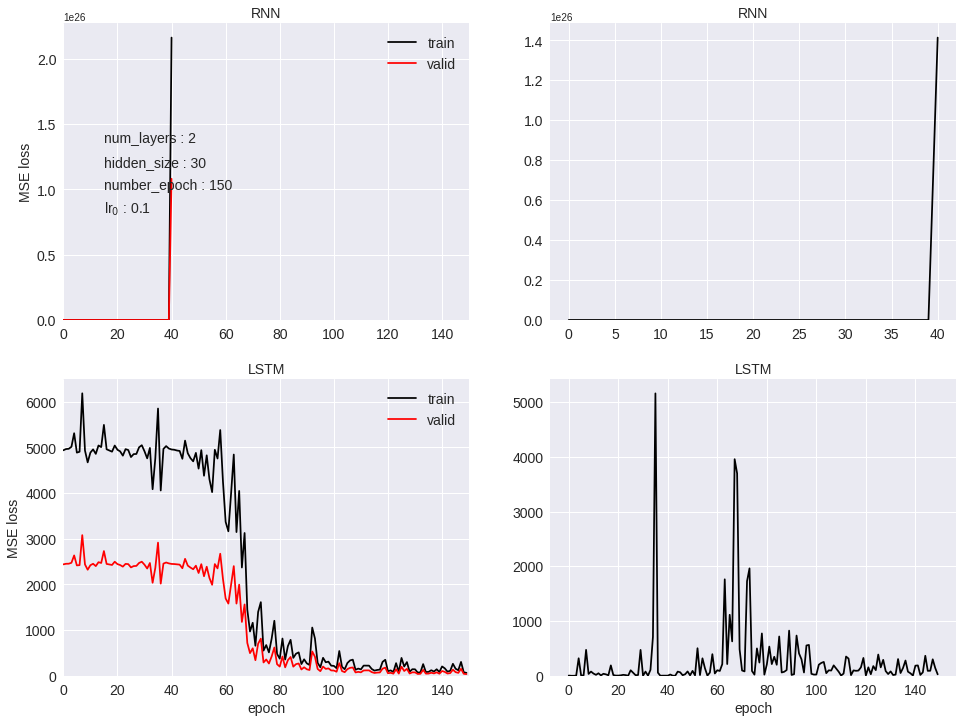

In [33]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))
ax1.plot(loss_train_data_rnn, '-k', label ='train')
ax1.plot(loss_valid_data_rnn, '-r', label = 'valid')

ax2.plot(total_norm_rnn, '-k', label = 'norm rnn')

ax3.plot(loss_train_data_lstm, '-k', label ='train')
ax3.plot(loss_valid_data_lstm, '-r', label = 'valid')

ax4.plot(total_norm_lstm, '-k', label = 'norm lstm')

ax3.set_xlabel('epoch', fontsize=14)
ax4.set_xlabel('epoch', fontsize=14)

ax1.set_ylabel('MSE loss', fontsize=14)	
ax3.set_ylabel('MSE loss', fontsize=14)	

ax1.set_title('RNN', fontsize = 14)
ax2.set_title('RNN', fontsize = 14)
ax3.set_title('LSTM', fontsize = 14)
ax4.set_title('LSTM', fontsize = 14)
legend = ax1.legend(loc='upper right', fontsize=14)
legend = ax3.legend(loc='upper right', fontsize=14)


ax1.set_xlim((0,number_epoch))
ax1.set_ylim((0))
ax2.set_ylim((0))
ax3.set_xlim((0,number_epoch))
ax3.set_ylim((0))
ax4.set_ylim((0))

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

ax1.text(0.1*(xmax - xmin) + xmin, 0.6*(ymax-ymin) + ymin,'num_layers : %.f'%num_layers, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.52*(ymax-ymin) + ymin,'hidden_size : %.f'%hidden_size, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.44*(ymax-ymin) + ymin,'number_epoch : %.f'%number_epoch, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.36*(ymax-ymin) + ymin,'lr$_0$ : %.1f'%lr0, fontsize=14)


for ax in [ax1,ax2,ax3,ax4]:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()          
    

In [140]:
total_norm_rnn

array([0.06250002, 0.06249998, 0.0625    , 0.06249999, 0.06249998,
       0.06250001, 0.0625    , 0.06249998, 0.06249999, 0.06249999])

Pour la suite, nous vous proposons d'intégrer ce jeu de données à un MLP, tel que présenté par Arsène Fansi Tchango.

Voici les données : 


In [0]:
'''
Train : N = 10000, T = 5, Les nombres de chaque séquence sont tirées entre 0 et 100. 
Valid : N = 1000
Talid : N = 1000
'''
xtrain,ytrain = data_set(10000,5,[-100,100])
xvalid,yvalid = data_set(1000,5,[-100,100])
xtest,ytest = data_set(1000,5,[-100,100])

batch_size = 100
  
all_data_train = data_utils.DataLoader(data_utils.TensorDataset(xtrain,ytrain), batch_size, shuffle=True)
all_data_valid = data_utils.DataLoader(data_utils.TensorDataset(xvalid,yvalid), batch_size, shuffle=False)
all_data_test = data_utils.DataLoader(data_utils.TensorDataset(xtest,ytest), batch_size, shuffle=False)

In [0]:
# MLP...

In [0]:
# p = torch.nn.utils.clip_grad_norm(model_rnn.parameters(), 0.5)      


In [0]:
  
#     def train(self, mode=True):
#         """Sets the module in training mode.
#         This has any effect only on modules such as Dropout or BatchNorm.
#         """
#         self.training = mode
#         for module in self.children():
#             module.train(mode)
#         return self      
    
#     def eval(self):
#         """Sets the module in evaluation mode.
#         This has any effect only on modules such as Dropout or BatchNorm.
#         """
#         return self.train(False)     
#   para = []
# grad_para = []

# for p in model.parameters():
#   para.append(p.data)
#   grad_para.append(p.grad)  
  

In [0]:
# cuda = True 

# input_size = 1
# num_layers = 2
# hidden_size = 2
# number_epoch = 20;
# N = 10000
# batch_size = 100
# lr0 = 0.004


# T = [3,5,10,20,40,60,80,100]

# total_norm_rnn = np.array([])
# total_norm_lstm = np.array([])
# total_norm_rnn_all = []
# total_norm_lstm_all = []


# t0 = time.clock()
# for i, T_ in enumerate(T):
#   print('For T = %f'%T_)
#   xtrain,ytrain = data_set(N,T_,[-100,100])
  
#   all_data_train = data_utils.DataLoader(data_utils.TensorDataset(xtrain,ytrain), batch_size, shuffle=False)
  
#   model_rnn = RnnLinear(input_size, hidden_size, num_layers,'rnn',cuda)
#   model_lstm = RnnLinear(input_size, hidden_size, num_layers,'lstm',cuda)
#   optimizer_rnn = optim.SGD(model_rnn.parameters(),lr=lr0)
#   optimizer_lstm = optim.SGD(model_lstm.parameters(),lr=lr0)

#   model_rnn.train()
    
#   ###### RNN ######
#   norm_rnn = np.array([])
#   norm_lstm = np.array([])  
#   for epoch in range(number_epoch):
#     for batch_idx, (xx, yy) in enumerate(all_data_train):                
#       xx,yy = model_rnn.input_format(xx,yy)
#       pred_batch_rnn = model_rnn(xx)
#       optimizer_rnn.zero_grad()
#       loss_batch_rnn = model_rnn.criterion(pred_batch_rnn,yy)
#       loss_batch_rnn.backward()
#       optimizer_rnn.step()

#     model_rnn.eval()
#     norm_rnn = np.append(norm_rnn,model_rnn.grad_norm()) #/T_

#   ###### LSTM ######
    
#     model_lstm.train()
#     for batch_idx, (xx, yy) in enumerate(all_data_train):
#       xx,yy = model_lstm.input_format(xx,yy)
#       pred_batch_lstm = model_lstm(xx)
#       optimizer_lstm.zero_grad()
#       loss_batch_lstm = model_lstm.criterion(pred_batch_lstm,yy)
#       loss_batch_lstm.backward()
#       optimizer_lstm.step()
  
#     model_lstm.eval()    
#     norm_lstm = np.append(norm_lstm,model_lstm.grad_norm())  #/T_
    
#     if epoch%2 ==0: print('Epoch #%.f     Gradient norm: RNN = %.5f,   LSTM = %.5f'%(epoch,norm_rnn[epoch],norm_lstm[epoch]))
#   total_norm_rnn_all.append(norm_rnn)
#   total_norm_lstm_all.append(norm_lstm)

# #   print('T = %.f, RNN, Norm gradient= %.5f  ----    LSTM, Norm gradient = %.5f'%(T_,norm_rnn[i],norm_rnn[i]))
    
# tf = time.clock()
# print('Terminé, %.1f sec'%(tf-t0))
  

In [0]:
# norm_rnn

In [0]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

# ax1.plot(T,total_norm_rnn,'-ok',label ='Grad norm')
# ax2.plot(T,total_norm_lstm,'-ok',label = 'Grad norm')


# ax1.set_ylabel('Gradien norm',fontsize=14)	
# ax1.set_xlabel('Sequence lenght',fontsize=14)	
# ax2.set_xlabel('Sequence lenght',fontsize=14)	

# ax1.set_title('RNN', fontsize = 14)
# ax2.set_title('LSTM', fontsize = 14)

# ax1.set_xlim((0))
# ax1.set_ylim((0))
# ax3.set_xlim((0))
# ax3.set_ylim((0))


# for ax in [ax1,ax2]:
#   for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

# plt.show()          
    